# Pytorch Lightning

In [1]:
# Only run once
#!pip install pytorch-lightning torch_geometric torch-scatter torch-sparse torch-cluster --quiet

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import pytorch_lightning as pl
import numpy as np

In [3]:
from torch_geometric.data import Data
import torch
import numpy as np

def generate_sample_graph(n_nodes=64, dn=8, k=3):
    x_vals = torch.linspace(0, 2 * np.pi, n_nodes)
    phase = np.random.uniform(0, 2 * np.pi)
    y_true = torch.sin(x_vals + phase)

    y_obs = torch.full_like(y_true, float('nan'))
    idx = torch.arange(0, n_nodes, dn)
    y_obs[idx] = y_true[idx]

    is_observed = ~torch.isnan(y_obs)
    input_feat = torch.stack([
        torch.nan_to_num(y_obs, nan=0.0),
        is_observed.float()
    ], dim=1)

    # k-nearest neighbors (left and right)
    edges = []
    for i in range(n_nodes):
        for j in range(1, k + 1):
            if i - j >= 0:
                edges.append((i, i - j))
            if i + j < n_nodes:
                edges.append((i, i + j))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(
        x=x_vals.unsqueeze(1),
        y=y_true.unsqueeze(1),
        y_obs=y_obs.unsqueeze(1),
        x_feat=input_feat,
        edge_index=edge_index
    )

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pytorch_lightning as pl

n1, n2 = 32, 16

class GNNInterpolator(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.gcn1 = GCNConv(2, n1)  # 2 input features
        self.gcn2 = GCNConv(n1, n2)
        self.out = GCNConv(n2, 1)

    def forward(self, data):
        x = data.x_feat
        x = F.relu(self.gcn1(x, data.edge_index))
        x = F.relu(self.gcn2(x, data.edge_index))
        return self.out(x, data.edge_index)

    def training_step(self, batch, batch_idx):
        pred = self(batch)
        mask = ~torch.isnan(batch.y_obs)
        loss = F.mse_loss(pred[~mask], batch.y[~mask])
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [5]:
from torch_geometric.loader import DataLoader

# Create dataset
dataset = [generate_sample_graph(n_nodes=64, dn=8, k=3) for _ in range(200)]
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Train
model = GNNInterpolator()
trainer = pl.Trainer(max_epochs=200, logger=False, enable_checkpointing=False)
trainer.fit(model, loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gcn1 | GCNConv | 96     | train
1 | gcn2 | GCNConv | 528    | train
2 | out  | GCNConv | 17     | train
-----------------------------------------
641       Trainable params
0         Non-trainable params
641       Total params
0.003     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=200` reached.


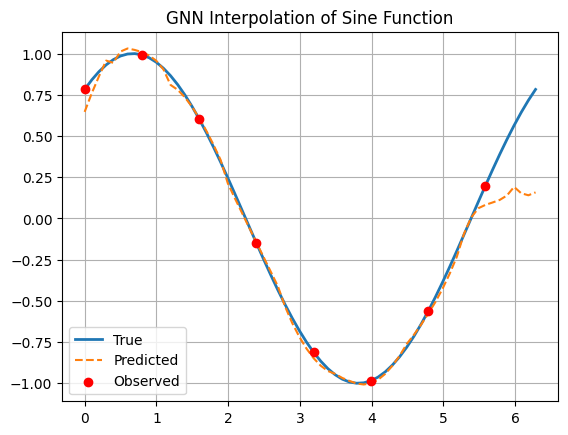

In [6]:
import matplotlib.pyplot as plt

test_data = generate_sample_graph(n_nodes=64, dn=8, k=3)
test_data.batch = torch.zeros(test_data.num_nodes, dtype=torch.long)

with torch.no_grad():
    pred = model(test_data).squeeze().cpu()
    true = test_data.y.squeeze()
    obs = test_data.y_obs.squeeze()
    x = test_data.x.squeeze()

plt.plot(x, true, label="True", linewidth=2)
plt.plot(x, pred, label="Predicted", linestyle='--')
plt.scatter(x[~torch.isnan(obs)], obs[~torch.isnan(obs)], color="red", label="Observed", zorder=5)
plt.legend()
plt.title("GNN Interpolation of Sine Function")
plt.grid(True)
plt.savefig("lightning_demo.png")
plt.show()